In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc,RocCurveDisplay
import kds
from imblearn.over_sampling import SMOTE 
import xgboost as xgb


In [2]:
df = pd.read_csv("Preprocessed.csv")

In [11]:
df.head()
asd = pd.DataFrame(df['AcceptedCmp6'].value_counts()).reset_index()
asd['percentage'] = (asd['count']/asd['count'].sum())*100
asd

,AcceptedCmp6,count,percentage
0,0,1734,84.792176
1,1,311,15.207824


### Our Baseline Accuracy should be above 84.79%
But we define our own profit function


In [3]:
X = df.drop(columns="AcceptedCmp6")
y = df["AcceptedCmp6"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Defining Custom Profit Function

In [4]:
sale_revenue = 11
call_cost = 3
false_positive_cost = call_cost

def calculate_profit(y_true, y_pred):
    tn, fp, fn, tp= confusion_matrix(y_true, y_pred).ravel() #tn, fp, fn, tp
    profit_from_sales = tp * (sale_revenue - call_cost)
    loss_from_wasted_calls = fp * false_positive_cost
    total_profit = profit_from_sales - loss_from_wasted_calls
    return total_profit

def profit_scorer(y_true, y_pred):
    return calculate_profit(y_true, y_pred)

scorer = make_scorer(profit_scorer, greater_is_better=True)




## Functions for finding the best thresholds

In [5]:
def evaluate_thresholds(model, X, y_true, thresholds, sale_revenue, call_cost):
    """
    Evaluate different thresholds to find the one that maximizes profit.

    Parameters:
    - model: Trained model that predicts probabilities (with a `predict_proba` method).
    - X: Feature matrix for evaluation.
    - y_true: True labels (0 or 1).
    - thresholds: List or array of thresholds to evaluate.
    - sale_revenue: Revenue from a successful sale.
    - call_cost: Cost of making a call.

    Returns:
    - best_threshold: The threshold that yields the highest profit.
    - profits: Dictionary with thresholds as keys and corresponding profits as values.
    """
    profits = {}
    for threshold in thresholds:
        # Get predicted probabilities and convert them to class predictions based on the threshold
        y_prob = model.predict_proba(X)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        # Calculate profit for this threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        profit_from_sales = tp * (sale_revenue - call_cost)
        loss_from_wasted_calls = fp * call_cost
        total_profit = profit_from_sales - loss_from_wasted_calls
        profits[threshold] = total_profit

    # Find the best threshold
    best_threshold = max(profits, key=profits.get)

    return best_threshold, profits

thresholds = np.arange(0.0, 1.01, 0.05)


## Setting up GridSearchCV

In [7]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 6,7],
    'criterion': ['entropy'],      
    'max_features': ['log2'],     
    'bootstrap': [True, False]              
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring= scorer)
grid_search.fit(X_train,y_train )


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'bootstrap': [True, False], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'max_features': ['log2'],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(profit_scorer, response_method='predict'))

In [8]:
best_model = grid_search.best_estimator_
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
profit_scorer(y_test,y_pred)



np.int64(344)

# Finding the best threshold for maximizing profit

In [11]:

best_threshold, profits = evaluate_thresholds(
    model=best_model,
    X=X_test,
    y_true=y_test,
    thresholds=thresholds,
    sale_revenue=11,
    call_cost=3
)


NameError: name 'best_model' is not defined

In [10]:
print(f"Best threshold: {best_threshold}")
print(f"Profits by threshold: {profits}")

Best threshold: 0.5
Profits by threshold: {np.float64(0.0): np.int64(-623), np.float64(0.05): np.int64(-596), np.float64(0.1): np.int64(-479), np.float64(0.15000000000000002): np.int64(-385), np.float64(0.2): np.int64(-262), np.float64(0.25): np.int64(-111), np.float64(0.30000000000000004): np.int64(40), np.float64(0.35000000000000003): np.int64(157), np.float64(0.4): np.int64(236), np.float64(0.45): np.int64(315), np.float64(0.5): np.int64(344), np.float64(0.55): np.int64(328), np.float64(0.6000000000000001): np.int64(299), np.float64(0.65): np.int64(227), np.float64(0.7000000000000001): np.int64(162), np.float64(0.75): np.int64(111), np.float64(0.8): np.int64(58), np.float64(0.8500000000000001): np.int64(24), np.float64(0.9): np.int64(8), np.float64(0.9500000000000001): np.int64(0), np.float64(1.0): np.int64(0)}


# Cumulative Gains

### Conclusions

Here we can see, that by calling only 40% of our customers we can identify almost 90% of our potential buyers. 

### Trying cummulative gains differently

Text(0, 0.5, 'Cumulative Gain (Proportion of True Positives)')

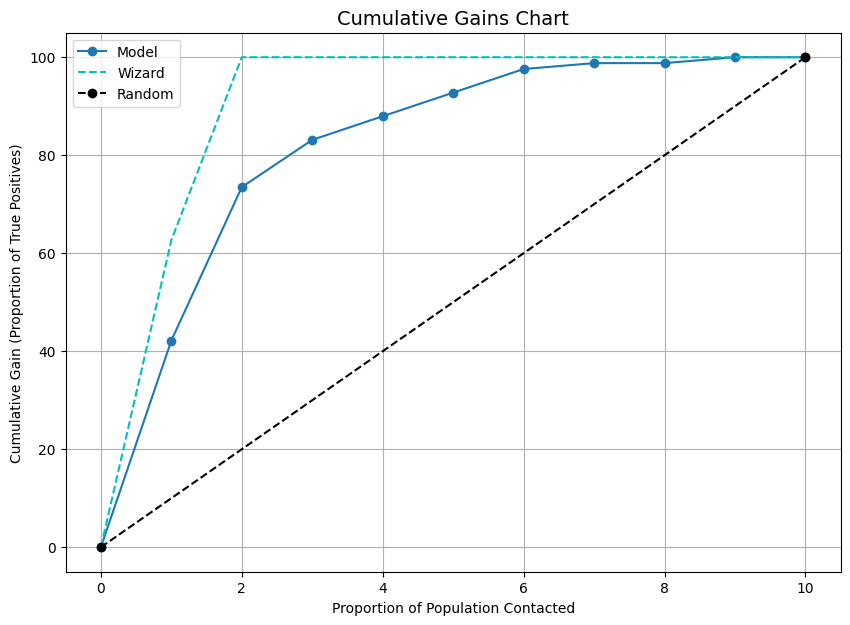

In [11]:
rf_probs =  best_model.predict_proba(X_test)
plt.figure(figsize=(10,7))
kds.metrics.plot_cumulative_gain(y_test, rf_probs[:,1], title="Cumulative Gains Chart")
plt.xlabel('Proportion of Population Contacted')
plt.ylabel('Cumulative Gain (Proportion of True Positives)')

## Lift Curve

Purpose: A lift chart shows how much better the model performs compared to random guessing (or a baseline model).  
Calculation: The lift is calculated as the ratio of the model's performance over random guessing.  
>Lift at a particular point = Gain at that point / Random model (random selection) gain at that point   


X-axis: Proportion of data (typically, this is the percentage of the total data that you have ranked by predicted probability, e.g., top 10% of predictions).  
Y-axis: Lift, which shows how much better the model is compared to random chance.


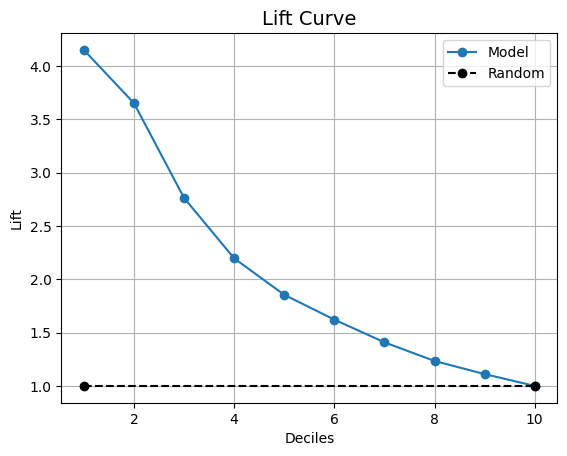

In [12]:
plt.figure()
kds.metrics.plot_lift(y_test, rf_probs[:,1], title="Lift Curve")


## ROC curve

The curve highlights the cost of increasing sensitivity (e.g., catching more true positives) at the expense of specificity (e.g., generating more false positives).

x axis: False Positive rate: Out of the negative instances, how many of them are falsely identified as positives    
y axis: True Positive Rate: Precentage of positive instances identified out of all the positive instances  

#### AUC - Area Under The Curve  
Defines how well the model can distinguish between positive and negative classes.  
>AUC = 1 -> Perfect disrimination  
>AUC = 0.5 -> Model is no better than random guessing

PS: ROC curves can be a good tool when comparing the performance of multiple models

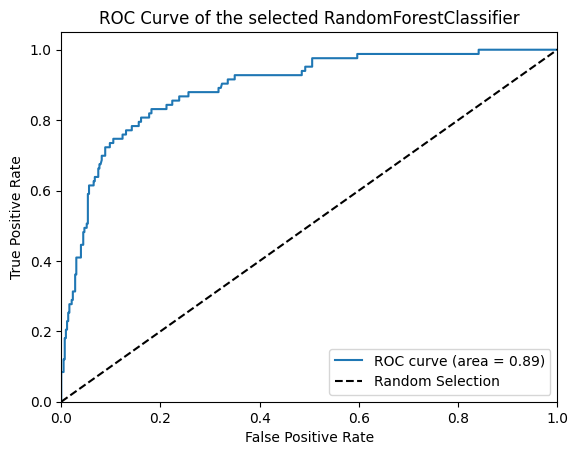

In [13]:
fpr, tpr, thresholds_roc = roc_curve(y_test, rf_probs[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'k--', label='Random Selection')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the selected RandomForestClassifier')
plt.legend()
plt.show()

### SMOTE - Synthetic Minority Over-sampling Technique

In [13]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [17]:
rf2 = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 6, 7, 8, 9],
    'criterion': ['gini','entropy'],      
    'max_features': ['sqrt','log2'],     
    'bootstrap': [True, False]              
}

grid_search = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=10, scoring= scorer)
grid_search.fit(X_train_res,y_train_res )


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(profit_scorer, response_method='predict'))

In [18]:
best_model = grid_search.best_estimator_
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
profit_scorer(y_test,y_pred)


np.int64(202)

In [19]:
thresholds = np.arange(0.0, 1.01, 0.05)
best_threshold, profits = evaluate_thresholds(
    model=best_model,
    X=X_test,
    y_true=y_test,
    thresholds=thresholds,
    sale_revenue=11,
    call_cost=3
)


In [20]:
print(f"Best threshold: {best_threshold}")
print(f"Profits by threshold: {profits}")

Best threshold: 0.25
Profits by threshold: {np.float64(0.0): np.int64(-623), np.float64(0.05): np.int64(-101), np.float64(0.1): np.int64(152), np.float64(0.15000000000000002): np.int64(286), np.float64(0.2): np.int64(310), np.float64(0.25): np.int64(313), np.float64(0.30000000000000004): np.int64(310), np.float64(0.35000000000000003): np.int64(282), np.float64(0.4): np.int64(255), np.float64(0.45): np.int64(257), np.float64(0.5): np.int64(202), np.float64(0.55): np.int64(155), np.float64(0.6000000000000001): np.int64(134), np.float64(0.65): np.int64(84), np.float64(0.7000000000000001): np.int64(69), np.float64(0.75): np.int64(64), np.float64(0.8): np.int64(32), np.float64(0.8500000000000001): np.int64(16), np.float64(0.9): np.int64(0), np.float64(0.9500000000000001): np.int64(0), np.float64(1.0): np.int64(0)}


In [21]:
rf_probs =  best_model.predict_proba(X_test)

Text(0, 0.5, 'Cumulative Gain (Proportion of True Positives)')

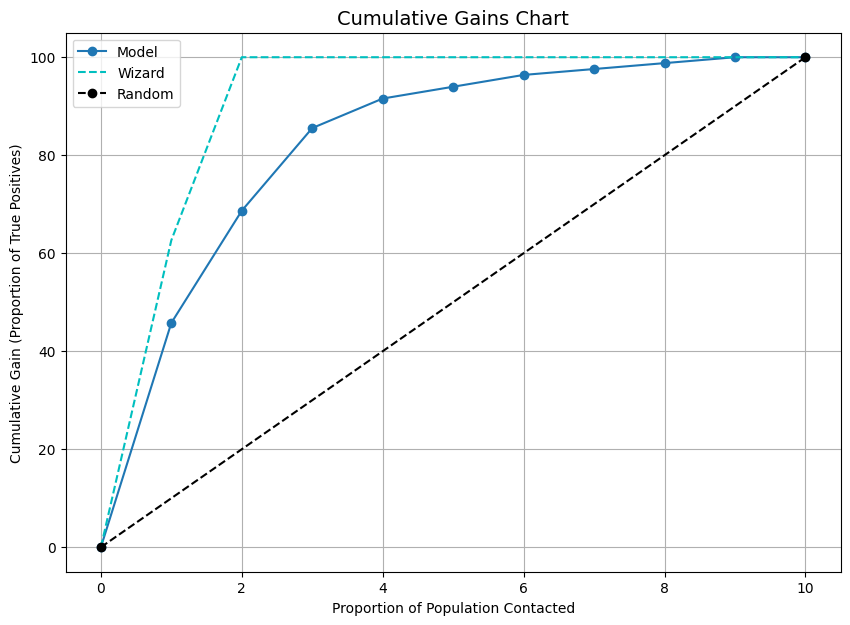

In [22]:
plt.figure(figsize=(10,7))
kds.metrics.plot_cumulative_gain(y_test, rf_probs[:,1], title="Cumulative Gains Chart")
plt.xlabel('Proportion of Population Contacted')
plt.ylabel('Cumulative Gain (Proportion of True Positives)')

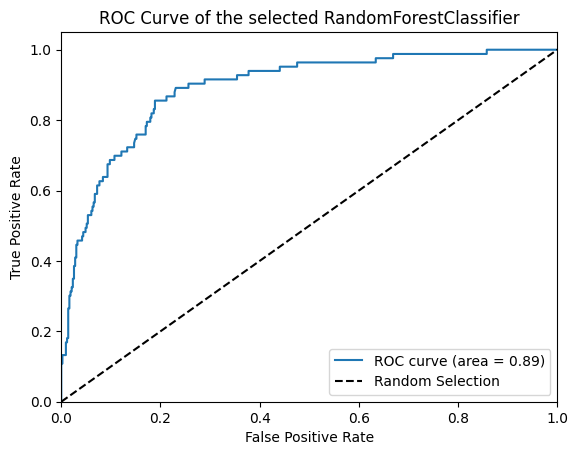

In [23]:
fpr, tpr, thresholds_roc = roc_curve(y_test, rf_probs[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'k--', label='Random Selection')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the selected RandomForestClassifier')
plt.legend()
plt.show()

## XGBoost

In [6]:

params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }

xgbclf = xgb.XGBClassifier(**params)


In [7]:
xgbclf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
y_pred = xgbclf.predict(X_test)
profit_scorer(y_test, y_pred)

np.int64(273)

In [13]:
evaluate_thresholds(xgbclf,X_test,y_test, thresholds, 11,3 )

(np.float64(0.25),
 {np.float64(0.0): np.int64(-623),
  np.float64(0.05): np.int64(123),
  np.float64(0.1): np.int64(248),
  np.float64(0.15000000000000002): np.int64(308),
  np.float64(0.2): np.int64(321),
  np.float64(0.25): np.int64(351),
  np.float64(0.30000000000000004): np.int64(330),
  np.float64(0.35000000000000003): np.int64(314),
  np.float64(0.4): np.int64(309),
  np.float64(0.45): np.int64(296),
  np.float64(0.5): np.int64(273),
  np.float64(0.55): np.int64(261),
  np.float64(0.6000000000000001): np.int64(251),
  np.float64(0.65): np.int64(228),
  np.float64(0.7000000000000001): np.int64(186),
  np.float64(0.75): np.int64(146),
  np.float64(0.8): np.int64(101),
  np.float64(0.8500000000000001): np.int64(93),
  np.float64(0.9): np.int64(61),
  np.float64(0.9500000000000001): np.int64(16),
  np.float64(1.0): np.int64(0)})

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       429
           1       0.75      0.47      0.58        83

    accuracy                           0.89       512
   macro avg       0.83      0.72      0.76       512
weighted avg       0.88      0.89      0.88       512



In [19]:
xgbclfgs = xgb.XGBClassifier(random_state = 42)

params = { 
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'learning_rate': [0.001, 0.01, 0.1, 0.20, 0.25, 0.30],
    "gamma":[0, 0.25, 0.5, 0.75,1],
    'n_estimators': [100, 500, 1000],
    "subsample":[0.9],
    "colsample_bytree":[0.5],
    "early_stopping_rounds": [10]
}
grid = GridSearchCV(
    estimator = xgbclfgs,
    param_grid = params,
    scoring = scorer,
    n_jobs = -1,
    cv = 5,
    verbose = 3,
)

grid = grid.fit(X_train, y_train,eval_set=[(X_test, y_test)])

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[0]	validation_0-logloss:0.40663
[1]	validation_0-logloss:0.38249
[2]	validation_0-logloss:0.37124
[3]	validation_0-logloss:0.35896
[4]	validation_0-logloss:0.33644
[5]	validation_0-logloss:0.32329
[6]	validation_0-logloss:0.30779
[7]	validation_0-logloss:0.30307
[8]	validation_0-logloss:0.29889
[9]	validation_0-logloss:0.29720
[10]	validation_0-logloss:0.29496
[11]	validation_0-logloss:0.29226
[12]	validation_0-logloss:0.28595
[13]	validation_0-logloss:0.28490
[14]	validation_0-logloss:0.28318
[15]	validation_0-logloss:0.28296
[16]	validation_0-logloss:0.28319
[17]	validation_0-logloss:0.28307
[18]	validation_0-logloss:0.28087
[19]	validation_0-logloss:0.28162
[20]	validation_0-logloss:0.28049
[21]	validation_0-logloss:0.27806
[22]	validation_0-logloss:0.27924
[23]	validation_0-logloss:0.27909
[24]	validation_0-logloss:0.27715
[25]	validation_0-logloss:0.27548
[26]	validation_0-logloss:0.27692
[27]	validation_0-logloss:0.

In [21]:
best_model = grid.best_estimator_
best_model.fit(X_train,y_train,eval_set=[(X_test, y_test)])
y_pred = best_model.predict(X_test)
profit_scorer(y_test,y_pred)


[0]	validation_0-logloss:0.40663


[1]	validation_0-logloss:0.38249
[2]	validation_0-logloss:0.37124
[3]	validation_0-logloss:0.35896
[4]	validation_0-logloss:0.33644
[5]	validation_0-logloss:0.32329
[6]	validation_0-logloss:0.30779
[7]	validation_0-logloss:0.30307
[8]	validation_0-logloss:0.29889
[9]	validation_0-logloss:0.29720
[10]	validation_0-logloss:0.29496
[11]	validation_0-logloss:0.29226
[12]	validation_0-logloss:0.28595
[13]	validation_0-logloss:0.28490
[14]	validation_0-logloss:0.28318
[15]	validation_0-logloss:0.28296
[16]	validation_0-logloss:0.28319
[17]	validation_0-logloss:0.28307
[18]	validation_0-logloss:0.28087
[19]	validation_0-logloss:0.28162
[20]	validation_0-logloss:0.28049
[21]	validation_0-logloss:0.27806
[22]	validation_0-logloss:0.27924
[23]	validation_0-logloss:0.27909
[24]	validation_0-logloss:0.27715
[25]	validation_0-logloss:0.27548
[26]	validation_0-logloss:0.27692
[27]	validation_0-logloss:0.27432
[28]	validation_0-logloss:0.27281
[29]	validation_0-logloss:0.27348
[30]	validation_0-loglo

np.int64(238)

In [22]:
profit_scorer(y_test,y_pred)

np.int64(238)

In [23]:
evaluate_thresholds(best_model,X_test,y_test, thresholds, 11,3 )

(np.float64(0.2),
 {np.float64(0.0): np.int64(-623),
  np.float64(0.05): np.int64(86),
  np.float64(0.1): np.int64(283),
  np.float64(0.15000000000000002): np.int64(327),
  np.float64(0.2): np.int64(330),
  np.float64(0.25): np.int64(326),
  np.float64(0.30000000000000004): np.int64(309),
  np.float64(0.35000000000000003): np.int64(287),
  np.float64(0.4): np.int64(269),
  np.float64(0.45): np.int64(238),
  np.float64(0.5): np.int64(238),
  np.float64(0.55): np.int64(242),
  np.float64(0.6000000000000001): np.int64(200),
  np.float64(0.65): np.int64(187),
  np.float64(0.7000000000000001): np.int64(169),
  np.float64(0.75): np.int64(140),
  np.float64(0.8): np.int64(104),
  np.float64(0.8500000000000001): np.int64(72),
  np.float64(0.9): np.int64(40),
  np.float64(0.9500000000000001): np.int64(16),
  np.float64(1.0): np.int64(0)})

In [24]:
grid.best_params_

{'colsample_bytree': 0.5,
 'early_stopping_rounds': 10,
 'gamma': 0.75,
 'learning_rate': 0.3,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.9}

In [6]:
print("Hello WOrld")

Hello WOrld
